In [2]:
using DifferentialEquations, ParameterizedFunctions
using Plots

### 1. air situation
状态：u = [x, y, z, vx, vy, vz]

参数：p = [g, l0, α, β]

In [3]:
function calc_foot_end(u, p)
    """ calculate the foot position in air """
    x, y, z = u[1:3]
    l0, α, β = p[2:4]
    x_pf = x + l0*cos(β)sin(α)
    y_pf = y + l0*sin(β)
    z_pf = z - l0*cos(β)cos(α)
    return (x_pf, y_pf, z_pf)
end

calc_foot_end (generic function with 1 method)

In [4]:
function diff_fun_fly!(du, u, p, t)
    """ Differential Equations in air"""
    x, y, z, vx, vy, vz = u
    g = p[1]
    du[1], du[2], du[3] = dx, dy, dz = vx, vy, vz
    du[4], du[5], du[6] = 0.0, 0.0, -g 
end

cond_contact(u, t, integrator) = calc_foot_end(u, integrator.p)[3]  # positive-->negative
affect_contact!(integrator) = terminate!(integrator)
cond_peak(u, t, integrator) = u[6]

cond_peak (generic function with 1 method)

### 2. ground situation

参数：p2 = [m, g, l0, k1, k2, x0, y0, z0]

In [5]:
# controller
function compressingCalc(u, p)
    """ decide if on compressing """
    x, y, z, vx, vy, vz = u
    x0, y0, z0 = p[6:8]
    vec1 = transpose([x-x0, y-y0, z])  # ground-->mass point
    vec2 = [vx, vy, vz]                # velocity vector
    return vec1*vec2
end
function k1k2Force(u, p)
    """ Control law1: using fixed k1, k2 model """
    k1, k2, x0, y0, z0 = p[4:8]
    l0 = p[3]
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    k = compressingCalc(u, p)<=0 ? k1 : k2

    fx = - k * (x - (x0 - l0*(x0-x)/l))
    fy = - k * (y - (y0 - l0*(y0-y)/l))
    fz = - k * (z - ( 0 - l0*(z0-z)/l))
    return (fx, fy, fz)
end
function jointForce(u, p)
    """Calculation: k force --> joint force"""
    k1, k2, x0, y0, z0 = p[4:8]
    l0 = p[3]
    x, y, z= u[1:3]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-0)^2)
    k = compressingCalc(u, p)<=0 ? k1 : k2
    kforce = k*abs(l0-l)
    tmp = l0^2 - l^2
    if tmp < 0
        if tmp > -0.001
            tmp = 0.0
        else
            println("error in mass point position")
        end
    end
    torque = kforce * sqrt(tmp)/2
    return torque
end

jointForce (generic function with 1 method)

In [6]:
function diff_fun_support!(du, u, p, t)
    """ Differential Equations on ground """
    m, g = p[1:2]
    x, y, z, vx, vy, vz = u
    
    fx, fy, fz = k1k2Force(u, p)          # force specification
    ax, ay, az = fx/m, fy/m, (fz-m*g)/m
    du[1], du[2], du[3] = vx, vy, vz
    du[4], du[5], du[6] = ax, ay, az
end

function cond_compressed(u, t, integrator)
    x, y, z, vx, vy, vz = u
    x0, y0, z0 = integrator.p[6:8]
    vec1 = transpose([x-x0, y-y0, z])  # ground-->mass point
    vec2 = [vx, vy, vz]                # velocity vector
    return vec1*vec2                   # negative-->positive
end

function cond_leave(u, t, integrator)
    """ Condition: Leave ground """
    x, y, z = u[1:3]
    x0, y0, z0 = integrator.p[6:8]
    l = sqrt((x-x0)^2 + (y-y0)^2 + (z-z0)^2)
    return (l - integrator.p[3])
end

cond_leave (generic function with 1 method)

### 3. 综合
初始条件：s0 = [z0, vx0, vy0]

控制器条件：ctrl = [[α, β, k1, k2]]

返回值：有效轨迹，足地接触点

In [7]:
function cycleCalc(m, l0, s0, ctrl)
    α, β, k1, k2 = ctrl
    z0, vx0, vy0 = s0
    u0 = [0.0, 0.0, z0, vx0, vy0, 0.0]
    tspan = (0.0, 4.0)
    p1 = (9.8, l0, α, β, k1, k2)
    ```------------------------------------------------------
    segment1, air-->contact
    the initial foot positon is not supposed to be underground!
    ---------------------------------------------------------```
    if(calc_foot_end(u0, p1)[3] <= 0)           # check
        return ([], [], [p1,])
    end
    
    prob = ODEProblem(diff_fun_fly!, u0, tspan, p1)
    cb = ContinuousCallback(cond_contact, affect_contact!)
    sol1 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    
    ```------------------------------------------------------
    segment2, compressing
    if segment1 end with opposite velocity, simulation may get wired!
    --------------------------------------------------------```
    u0 = sol1.u[end]    
    foot_p = calc_foot_end(u0, p1)
    p2 = [m, 9.8, l0, k1, k2, foot_p...]
    if(compressingCalc(u0, p2) >= 0)
        return ([sol1,], foot_p, [p1, p2])               # check
    end
    
    prob = ODEProblem(diff_fun_support!, u0, tspan, p2)
    cb = ContinuousCallback(cond_compressed, terminate!)
    sol2 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)

    ```-----------------------------------------------------
    segment3, thrusting
    compressing should not be too much! small k
    ------------------------------------------------------```
    u0, p3 = sol2.u[end], p2
    if(u0[3] <= 0)
        return ([sol1, sol2,], foot_p, [p1, p2, p3,])
    end
    prob = ODEProblem(diff_fun_support!, u0, tspan, p3)
    cb = ContinuousCallback(cond_leave, terminate!, abstol=1e-9)
    sol3 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    
    ```-----------------------------------------------------
    segment4, air up
    thrusting initial z velocity shou be positive
    ------------------------------------------------------```
    u0, p4 = sol3.u[end], p1
    if(u0[6] <= 0)
        return ([sol1, sol2, sol3,], foot_p, [p1, p2, p3,p4])
    end
    prob = ODEProblem(diff_fun_fly!, u0, tspan, p4)
    cb = ContinuousCallback(cond_peak, terminate!)
    sol4 = solve(prob, Tsit5(), callback=cb, saveat = 0.01)
    
    return ([sol1, sol2, sol3, sol4], foot_p, [p1, p2, p3, p4])
end

┌ Warning: special characters "#{}()[]<>|&*?~;" should now be quoted in commands
│   caller = #shell_parse#353(::String, ::typeof(Base.shell_parse), ::String, ::Bool) at shell.jl:100
└ @ Base ./shell.jl:100


cycleCalc (generic function with 1 method)

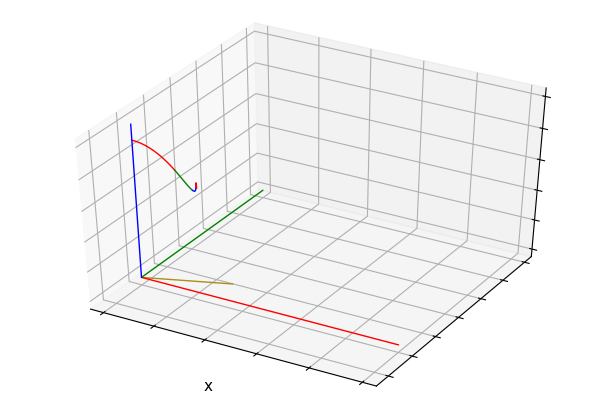

┌ Info: Saved animation to 
│   fn = /home/kuro/julia/Tutorial_julia/paper1/tmp.gif
└ @ Plots /home/kuro/.julia/packages/Plots/h3o4c/src/animation.jl:95


Plots.AnimatedGif("/home/kuro/julia/Tutorial_julia/paper1/tmp.gif")

In [53]:
pyplot(leg=false, ticks=nothing)
function test1(p)
    m , l0, s0, ctrl = p
    sol, foot_p, _ = cycleCalc(m, l0, s0, ctrl)
    if(size(sol)[1]<4)
        println("Param failed!")
        return
    end
    sol1, sol2, sol3, sol4 = sol
    x1, y1, z1 = [u[1] for u in sol1.u], [u[2] for u in sol1.u], [u[3] for u in sol1.u]
    x2, y2, z2 = [u[1] for u in sol2.u], [u[2] for u in sol2.u], [u[3] for u in sol2.u]
    x3, y3, z3 = [u[1] for u in sol3.u], [u[2] for u in sol3.u], [u[3] for u in sol3.u]
    x4, y4, z4 = [u[1] for u in sol4.u], [u[2] for u in sol4.u], [u[3] for u in sol4.u]
    p = plot3d(x1, y1, z1, color=[:red,])
    plot3d!(x2, y2, z2, color=[:green,])
    plot3d!(x3, y3, z3, color=[:blue,])
    plot3d!(x4, y4, z4, color=[:red,])
    plot3d!([0,foot_p[1]], [0,foot_p[2]], [0,foot_p[3]], seriestype=:scatter)
    plot3d!([0, 1], [0, 0], [0, 0], color=[:red,]);
    plot3d!([0, 0], [0, 1], [0, 0], color=[:green,]);
    plot3d!([0, 0], [0, 0], [0, 1], color=[:blue,]);
    xlabel!(p,"x");
    @gif for i in range(0, stop = 2π, length = 100)
        plot!(p, camera=(30*cos(i), 40)) # , aspect_ratio=:equal， 3D绘图好像不能设置这个
    end
end

# Test
p1 = (20, 0.8, [1.0, 1.0, 0.2], [pi/8, pi/9, 1e3, 1e3])
p2 = (20, 0.8, [0.9, 1.0, 0.0], [pi/18, pi/18, 1e4, 1e4])
test1(p2)

### 3.5 工具函数，计算仿真中间量

In [49]:
function maxJointTorque(sol, p)
    if(size(sol)[1] >= 2)
        u = sol[2].u[end]
        p2 = p[2]
        return jointForce(u, p2)
    else
        println("Error: no maxJointTorque!")
        return 0
    end
end

function jointTorqueAcc_Raw(sol, p)
    if(size(sol)[1] < 4)
        println("failed in testing")
        return 0
    end
    
    Tacc = 0
    sol1, sol2, sol3, sol4 = sol
    p1, p2, p3, p4 = p
    torque_1 = jointForce(sol2.u[1], p2)
    for i in 1:length(sol2.t)-1
        torque = jointForce(sol2.u[i+1], p2)
        Tacc += (torque_1 + torque)*(sol2.t[i+1] - sol2.t[i])/2
        torque_1 = torque
    end
    torque_1 = jointForce(sol3.u[1], p3)
    for i in 1:length(sol3.t)-1
        torque = jointForce(sol3.u[i+1], p3)
        Tacc += (torque_1 + torque)*(sol3.t[i+1] - sol3.t[i])/2
        torque_1 = torque
    end
    return Tacc
end

jointTorqueAcc_Raw (generic function with 1 method)

### 4. loss function design
在当前的设计下，参数主要是，初始条件（高度，速度），期望的终点条件（高度，速度），着地角度，以及两个k。需要考虑的性能主要包括：
1. 腿部的出力，出力应该映射到实际的关节设计上
2. 目标的达成情况，应该尽量达到期望的条件，但不强求
3. 插一个话题：可能这一个周期是能达到期望的条件，但以期望的条件为起点可能很难达到稳定的运行状态（问题）
4. 尽管失败的状态是不能达到期望的，我们还是应该在仿真阶段直接去掉这些样本

神经网络的设计应该是，输入<初始状态，期望状态>，输出一个控制参数，我们假定在优化中能够得到足够优秀的参数方案，也就是说在当前的条件下想要达到目标状态，这就已经是最佳方案了，因此我们可以直接用这些参数来进行设计，而我们同时也可以训练一个状态评价网络，这个网络用于制定目标状态；认为这种simplified结合神经网络以及传统算法将能够达到非常好的效果

考虑第一层的优化，优化的目标是首要稳定，其次接近目标状态，最后是出力优化，所谓的Multi-layer应该怎么处理？这里是一个非线性优化问题，并且需要构造一个[参数-->值]的函数

In [57]:
# 怎么确定惩罚的量级问题，以及怎么设计惩罚函数的问题
# h1 = -10:0.1:1;
# cost_seg1(x) = 1000 .*(1 .- exp.(x))
# y = cost_seg1(h1)
# index = findall(x->x<0, y)
# y[index] = zeros(length(index))
# plot(h1, y)
eff = 1000
cost1_func(x) = eff .*(1 .- exp.(x))
function cost_func1(x)
    tmp = 1-exp(x)
    return tmp>0 ? eff*tmp : 0
end
function evalSolution(sol, target, p)
    # 1. fail
    cost1 = 0;
    if(size(sol)[1]==3)
        p1, p2, p3, p4 = p
        cost1 = cost_func1(sol[3].u[end][6])
    elseif(size(sol)[1]==2)
        p1, p2, p3 = p
        cost1 = cost_func1(sol[2].u[end][3]) + eff
    elseif(size(sol)[1]==1)
        p1, p2 = p
        cost1 = cost_func1(-compressingCalc(sol[1].u[end], p2)) + 2*eff
        # println(compressingCalc(sol[1].u[end], p2), "  ",cost_func1(compressingCalc(sol[1].u[end], p2)), "  ", 2*eff)
    elseif(size(sol)[1]==0)
        p1 = p[1]
        cost1 = cost_func1(calc_foot_end(sol[1].u[1], p1)[3]) + 3*eff
    else
        p1, p2, p3, p4 = p
        cost1 = 0.0
    end
    if(size(sol)[1]<4)
        return cost1+2*eff, 0, 0
    end
    # 2. target reached, distance cost
    sol1, sol2, sol3, sol4 = sol
    real_end = sol4.u[end][3:5]
    err = real_end - target
    cost2 = (err[1]^2 + err[2]^2 + err[3]^2)*1000
    
    # 3. joint force cost
    # recommond district, capble district, unreachable district\
    # first not, because we dont know the real range!
    Tacc = 0
    torque_1 = jointForce(sol2.u[1], p2)
    for i in 1:length(sol2.t)-1
        torque = jointForce(sol2.u[i+1], p2)
        Tacc += (torque_1 + torque)*(sol2.t[i+1] - sol2.t[i])/2
        torque_1 = torque
    end
    torque_1 = jointForce(sol3.u[1], p3)
    for i in 1:length(sol3.t)-1
        torque = jointForce(sol3.u[i+1], p3)
        Tacc += (torque_1 + torque)*(sol3.t[i+1] - sol3.t[i])/2
        torque_1 = torque
    end
    cost3 = Tacc
    return cost1, cost2, cost3
end
function evalParam(m, l0, u0, target, ctrl)
    sol, foot_p, p = cycleCalc(m, l0, u0, ctrl)
    c1, c2, c3 = evalSolution(sol, target, p)
    return c1+c2+c3
end

# Test
p_cycle = (20, 0.8, [0.9, 1.0, 0.0], [pi/18, pi/18, 1e4, 1e4])
m , l0, u0, ctrl = p_cycle
evalParam(m, l0, u0, u0, ctrl)

1276.6269017729085

### 5. 求解优化参数
1. 优化目标设置为cost最小
2. 参数为对应的《初始状态，期望状态，控制量》

说明<br />
1. 目前julia的优化函数不支持用户自定义函数中包含外部库，只能自己用差分来写函数导数

In [ ]:
using JuMP
using Ipopt
Δdiff = 0.00001
function optFun(α,β, k1, k2)
    res = evalParam(20, 0.8, [0.9, 1.0, 0.0], [1.0, 0.8, 0.2], [α, β, k1*1000, k2*1000])
end
function ∇optFun(g, α,β, k1, k2)
    g[1] = α_df = (optFun(α+Δdiff,β, k1, k2)-optFun(α-Δdiff,β, k1, k2))/(2*Δdiff)
    g[2] = β_df = (optFun(α,β+Δdiff, k1, k2)-optFun(α,β-Δdiff, k1, k2))/(2*Δdiff)
    g[3] = k1_df = (optFun(α,β, k1+Δdiff, k2)-optFun(α,β, k1-Δdiff, k2))/(2*Δdiff)
    g[4] = k2_df = (optFun(α,β, k1, k2+Δdiff)-optFun(α,β, k1, k2-Δdiff))/(2*Δdiff)
    # println("para:", [α,β, k1, k2])
end

model = Model(with_optimizer(Ipopt.Optimizer, max_iter=38))
@variable(model, 1.0 <= k1 <= 10.0)
@variable(model, 1.0 <= k2 <= 10.0)
@variable(model, -pi/2 <= α <= pi/2)
@variable(model, -pi/2 <= β <= pi/2)
register(model, :optFun, 4,optFun, ∇optFun)
@NLobjective(model, Min, optFun(α, β, k1, k2))
mopt = optimize!(model)

In [ ]:
ctrl = [value(α), value(β), value(k1), value(k2)]

### 6. 调试

In [60]:
# ctrl2 = [0.28678316237174406, -0.002803495660065451, 1010.0267501534099, 1010.0264709279156];
ctrl2 = [0.15932352796868318 , -0.029932970949137754,  7.433066089458452*1000, 7.597399199338621*1000]
m, l0, u0 = 20, 0.8, [0.9, 1.0, 0.0]
sol, foot_p, p = cycleCalc(m, l0, u0, ctrl2);
c1, c2, c3 = evalSolution(sol, u0, p)
println([c1, c2, c3])
println(maxJointTorque(sol, p))

[0.0, 125.11134637885499, 17.627644122048395]
167.67519585939243


In [62]:
sol[4].u[end]

6-element Array{Float64,1}:
 0.4193931426381284    
 0.049219470999035037  
 0.9288413818415143    
 0.7061002889918148    
 0.19468559510562702   
 3.6342835487466693e-16

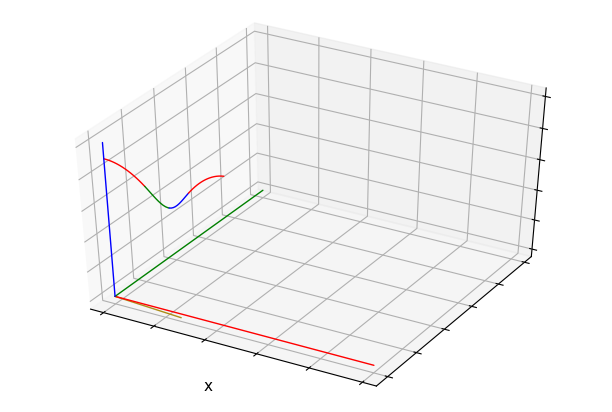

┌ Info: Saved animation to 
│   fn = /home/kuro/julia/Tutorial_julia/paper1/tmp.gif
└ @ Plots /home/kuro/.julia/packages/Plots/h3o4c/src/animation.jl:95


Plots.AnimatedGif("/home/kuro/julia/Tutorial_julia/paper1/tmp.gif")

In [61]:
cycle_p = (m, l0, u0, ctrl2)
test1(cycle_p)

### 实验1，刚度对过程做功的影响
结论：k越大，过程中的积分越小，但为什么优化的结果是偏向于小端？难以理解

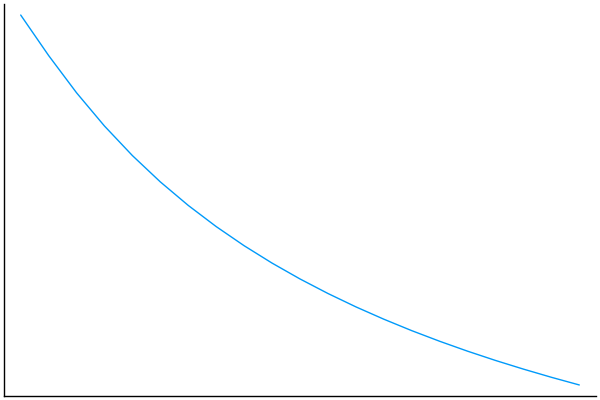

In [55]:
torqueAcc_list = []
for k in 1000.0:100:3000.0
    m, l0, u0 = 20, 0.8, [0.9, 1.0, 0.0]
    ctrl = [0.28678316237174406, -0.002803495660065451 , k , k]
    # ctrl = [pi/8, pi/9, k, k]
    sol, foot_p, p = cycleCalc(m, l0, u0, ctrl);
    append!(torqueAcc_list, jointTorqueAcc_Raw(sol, p))
end
plot(torqueAcc_list)